In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install ptflops
# from ptflops import get_model_complexity_info
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [8]:
# Hyper-parameter and setting
image_size = 224
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs_student = 10
num_classes = 31

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(123)

In [9]:
import torchvision.transforms as transforms
transformer = transforms.Compose([
    torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms(),
])

In [10]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset

DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'

amazon_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/amazon', transform=transformer)
dslr_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transformer)
webcam_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/webcam', transform=transformer)

classes = webcam_dataset.classes

Ds_amazon, Ds_amazon_test = random_split(amazon_dataset, [0.8, 0.2])
Ds_dslr, Ds_dslr_test = random_split(dslr_dataset, [0.8, 0.2])
Ds_webcam, Ds_webcam_test = random_split(webcam_dataset, [0.8, 0.2])

In [11]:
Dl_amazon = DataLoader(Ds_amazon, batch_size, shuffle=True, num_workers=2)
Dl_dslr = DataLoader(Ds_dslr, batch_size, shuffle=True, num_workers=2)
Dl_webcam = DataLoader(Ds_webcam, batch_size, shuffle=True, num_workers=2)

Dl_amazon_test = DataLoader(Ds_amazon_test, batch_size, shuffle=True, num_workers=2)
Dl_dslr_test = DataLoader(Ds_dslr_test, batch_size, shuffle=True, num_workers=2)
Dl_webcam_test = DataLoader(Ds_webcam_test, batch_size, shuffle=True, num_workers=2)

In [12]:
batch = next(iter(Dl_amazon))
print(batch[0].shape)

torch.Size([16, 3, 224, 224])


In [13]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [14]:
class CorrelationAlignmentLoss(nn.Module):
    def __init__(self):
        super(CorrelationAlignmentLoss, self).__init__()

    def forward(self, f_s: torch.Tensor, f_t: torch.Tensor) -> torch.Tensor:
        mean_s = f_s.mean(0, keepdim=True)
        mean_t = f_t.mean(0, keepdim=True)
        cent_s = f_s - mean_s
        cent_t = f_t - mean_t
        cov_s = torch.mm(cent_s.t(), cent_s) / (len(f_s) - 1)
        cov_t = torch.mm(cent_t.t(), cent_t) / (len(f_t) - 1)

        mean_diff = (mean_s - mean_t).pow(2).mean()
        cov_diff = (cov_s - cov_t).pow(2).mean()

        return mean_diff + cov_diff

In [15]:
lambda_coral = 1.0
loss_fn_class = torch.nn.CrossEntropyLoss()

In [16]:
# Training
def train(model, optimizer, Dl_source, Dl_target, Dl_test):
    max_batches = min(len(Dl_source), len(Dl_target))
    t_0 = time.time()
    training_logs_coral = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": [], "test_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct, test_correct = 0, 0, 0, 0
        
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)
        Dl_test_iter = iter(Dl_test)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)
            
            if (Dl_test_iter._num_yielded <= batch_idx):
                Dl_test_iter._reset(Dl_test)
            X_test, y_test = next(Dl_test_iter)

            if X_s.shape[0] != X_t.shape[0]:
                min_bs = min(X_s.shape[0], X_t.shape[0])
                X_s = X_s[:min_bs]
                y_s = y_s[:min_bs]
                X_t = X_t[:min_bs]
                y_t = y_t[:min_bs]


            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)
            X_test, y_test = X_test.to(device), y_test.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            
            loss_src = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = loss_src + lambda_coral * loss_coral
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
                class_prediction_s = model(X_s)
                class_prediction_t = model(X_t)
                class_prediction_test = model(X_test)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()
            test_correct += (class_prediction_test.argmax(1) == y_test).float().sum().item()

        training_logs_coral["train_loss"].append(train_loss / len(Dl_source))
        training_logs_coral["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_coral["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))
        training_logs_coral["test_acc"].append(test_correct / (batch_size*max_batches))
        
        if training_logs_coral["test_acc"][-1] == max(training_logs_coral["test_acc"]):
            torch.save(model.state_dict(), f'{path_save_cp}best_model.pth')

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Test_acc: {test_correct / (batch_size*max_batches)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

    t_end = time.time()-t_0
    print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

    plot_graph(training_logs_coral)

In [17]:
DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'
HOME = '/home/crueang/Chaks/AIOT_project'

In [18]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True, device='cpu'):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True).to(device)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [19]:
student_fn = torchvision.models.mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31).to(device)
student_fn.load_state_dict(torch.load('/home/crueang/Chaks/AIOT_project/democp/pretrained_mmd26/best_model.pth', weights_only=True, map_location=device))
summary(student_fn, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn.cpu().eval(), input_res=224, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

tensor(18659808.)

In [20]:
print(student_fn)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1,

In [21]:

import torch.nn.utils.prune as prune
import copy

# f_iterpruned = copy.deepcopy(f)

# prune.ln_structured(f_iterpruned[0], name="weight", amount=0.3, n=2, dim=0)

# As we can verify, this will zero out all the connections corresponding to
# 30% (~2 out of 6) of the channels, while preserving the action of the
# previous mask.
# for hook in f_iterpruned[0]._forward_pre_hooks.values():
#     if hook._tensor_name == "weight":  # select out the correct hook
#         break
def prune_conv_layer(layer, amount=0.5):
    """
    Prune the specified layer by removing 'amount' percentage of channels.
    """
    prune.ln_structured(layer, name="weight", amount=amount, n=1, dim=0)  # Prune filters (channels)


# Traverse through the model and prune convolutional layers
def apply_pruning(model, amount=0.5, threshold=5000):
    flag = 1
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            num_params = module.weight.numel()  # Get number of parameters in the layer
            if num_params > threshold:
                flag = 0
                print(f'Pruning layer {name} with {num_params} parameters')
                prune.l1_unstructured(module, name='weight', amount=amount)
                # prune.remove(module, 'weight')

            if flag == 1:
                for param in module.parameters():
                    param.requires_grad = False
                    print(f'Layer {name}: {num_params} parameters frozen')


# Apply pruning to the model
apply_pruning(student_fn, amount=0.2, threshold=1000)

def remove_pruning_masks(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            try:
                prune.remove(module, 'weight')
            except:
                pass

# remove_pruning_masks(student_fn)

# student_fn = torchvision.models.mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31).to(device)
summary(student_fn.to(device), input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn.cpu().eval(), input_res=224, multiply_adds=True)

Layer features.0.0: 216 parameters frozen
Layer features.0.1: 8 parameters frozen
Layer features.0.1: 8 parameters frozen
Layer features.1.block.0.0: 72 parameters frozen
Layer features.1.block.0.1: 8 parameters frozen
Layer features.1.block.0.1: 8 parameters frozen
Layer features.1.block.1.fc1: 64 parameters frozen
Layer features.1.block.1.fc1: 64 parameters frozen
Layer features.1.block.1.fc2: 64 parameters frozen
Layer features.1.block.1.fc2: 64 parameters frozen
Layer features.1.block.2.0: 64 parameters frozen
Layer features.1.block.2.1: 8 parameters frozen
Layer features.1.block.2.1: 8 parameters frozen
Layer features.2.block.0.0: 192 parameters frozen
Layer features.2.block.0.1: 24 parameters frozen
Layer features.2.block.0.1: 24 parameters frozen
Layer features.2.block.1.0: 216 parameters frozen
Layer features.2.block.1.1: 24 parameters frozen
Layer features.2.block.1.1: 24 parameters frozen
Layer features.2.block.2.0: 192 parameters frozen
Layer features.2.block.2.1: 8 paramete

tensor(17436188.)

In [15]:
# for module in student_fn.modules():
#     if hasattr(module, '_forward_hooks'):
#         print(module._forward_hooks)
#         module._forward_hooks.clear()
# torch.save(student_fn, 'model.pth')
# loaded = torch.load('/home/crueang/Chaks/AIOT_project/cp/mbv3_red_coral_A2D_prune_pre_structed_1k_freeze_before_0_2/model.pth')
# summary(loaded.to(device), input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=loaded.cpu().eval(), input_res=224, multiply_adds=True)

In [16]:
for name, module in student_fn.named_modules():
    print(name, module)

 MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1

In [22]:
DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'
HOME = '/home/crueang/Chaks/AIOT_project'

In [23]:
image_size = 224
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs = 50
num_classes = 31

In [24]:
import os
from tqdm import tqdm
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    training_logs = {"train_loss": [], "validate_loss": [], "train_acc": [], "validate_acc": []}
    epoch_number = 0
    best_test_loss = float('inf')

    if checkpoint_path:
      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['validate_loss']))
        
      if os.path.exists(checkpoint_path + 'model.pth'):
        model = torch.load(checkpoint_path + 'model.pth', weights_only=False, map_location=device)

      if os.path.exists(checkpoint_path + 'opt.pth'):
        opt.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))


    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()

    print("🤖Training on", device)
    for epoch in range(epoch_number, epochs):
        model = model.to(device)
        train_loss, train_correct = 0, 0
        model.train()
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, label in train_bar:
            images = images.to(device)
            label = label.to(device)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, label)
            loss.backward()
            opt.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == label).float().sum().item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_correct / len(train_loader.dataset)
        print(f'\n\tTrain loss: {avg_train_loss}')
        print(f'\tTrain acc: {avg_train_acc}')
        training_logs["train_loss"].append(avg_train_loss)
        training_logs["train_acc"].append(avg_train_acc)

        test_loss, test_correct = 0, 0
        model.eval()
        test_bar = tqdm(test_loader,desc='📄Testing',unit='batch')
        with torch.no_grad():
          for images, label in test_bar:
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, label)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == label).float().sum().item()
            
        avg_test_loss = test_loss / len(test_loader.dataset)
        avg_test_acc = test_correct / len(test_loader.dataset)
        print(f'\tTest loss: {avg_test_loss}')
        print(f'\tTest acc: {avg_test_acc}')
        training_logs["validate_loss"].append(avg_test_loss)
        training_logs["validate_acc"].append(avg_test_acc)

        if checkpoint_path:
            for module in model.modules():
                if hasattr(module, '_forward_hooks'):
                    module._forward_hooks.clear()
            torch.save(model.cpu().eval(), checkpoint_path + "model.pth")
            torch.save(opt.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > avg_test_loss:
               torch.save(model, checkpoint_path + "best_model.pth")
               best_test_loss = avg_test_loss

In [25]:
CP = '/home/crueang/Chaks/AIOT_project/democp'

In [26]:
# student_fn = torch.load(f'{HOME}/cp/mbv3_red_coral_A2D_prune_pre1/model.pth', weights_only=False, map_location=device)

optimizer = torch.optim.Adam(student_fn.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=False)
checkpoint_path = f'{CP}/prune/prune1/'


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
student_fn = student_fn.to(device)
summary(student_fn, (3, 224, 224))
count_model_param_flops(model=student_fn.cpu().eval(), input_res=224, multiply_adds=True)
train(student_fn, optimizer, criterion, train_loader, test_loader, 15, checkpoint_path, device=device)

In [30]:
loaded_model = torch.load(f'/home/crueang/Chaks/AIOT_project/democp/prune/prune1/best_model.pth', weights_only=False, map_location=device)
summary(loaded_model, (3, 224, 224))
count_model_param_flops(model=loaded_model.cpu().eval(), input_res=224, multiply_adds=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

tensor(17436188.)

In [11]:
class ExpandDataset(Dataset):
    def __init__(self, original_dataset, required_size):
        self.original_dataset = original_dataset
        self.required_size = required_size
        self.original_size = len(original_dataset)
    
    def __len__(self):
        return self.required_size
    
    def __getitem__(self, idx):
        # Select a random index from the original dataset to duplicate
        original_idx = idx % self.original_size  # Loop around if idx exceeds original size
        return self.original_dataset[original_idx]

expanded_dataset = ExpandDataset(dslr_dataset, 2817)
Dl_dslr = DataLoader(expanded_dataset, batch_size, shuffle=True)

In [81]:
# Training
def train_coral(model, optimizer, Dl_source, Dl_target, Dl_test, checkpoint_path):
    max_batches = min(len(Dl_source), len(Dl_target))
    t_0 = time.time()
    training_logs_coral = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    epoch_number = 0
    
    if checkpoint_path:
        if os.path.exists(checkpoint_path + 'model.pth'):
            model = torch.load(checkpoint_path + 'model.pth', weights_only=False, map_location=device)

        if os.path.exists(checkpoint_path + 'opt.pth'):
            optimizer.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

        if os.path.exists(checkpoint_path + 'training_logs.pth'):
            training_logs_coral = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
            epoch_number = len(training_logs_coral['train_loss'])
    
    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs_coral.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()
        
    for epoch_idx in range(epoch_number, num_epochs):
        train_loss, train_src_correct, train_tar_correct, test_correct = 0, 0, 0, 0
        
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)
        # Dl_test_iter = iter(Dl_test)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)
            
            # if (Dl_test_iter._num_yielded <= batch_idx):
            #     Dl_test_iter._reset(Dl_test)
            # X_test, y_test = next(Dl_test_iter)

            if X_s.shape[0] != X_t.shape[0]:
                min_bs = min(X_s.shape[0], X_t.shape[0])
                X_s = X_s[:min_bs]
                y_s = y_s[:min_bs]
                X_t = X_t[:min_bs]
                y_t = y_t[:min_bs]


            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)
            # X_test, y_test = X_test.to(device), y_test.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            
            loss_src = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = loss_src + lambda_coral * loss_coral
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
                class_prediction_s = model(X_s)
                class_prediction_t = model(X_t)
            #     class_prediction_test = model(X_test)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()
            # test_correct += (class_prediction_test.argmax(1) == y_test).float().sum().item()

        training_logs_coral["train_loss"].append(train_loss / len(Dl_source))
        training_logs_coral["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_coral["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))
        # training_logs_coral["test_acc"].append(test_correct / (batch_size*max_batches))
        
        if training_logs_coral["train_tar_acc"][-1] == max(training_logs_coral["train_tar_acc"]):
            torch.save(model, f'{checkpoint_path}best_model.pth')
            
        torch.save(model, checkpoint_path + "model.pth")
        torch.save(optimizer.state_dict(), checkpoint_path + "opt.pth")
        torch.save(training_logs_coral, checkpoint_path + 'training_logs.pth')

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

    t_end = time.time()-t_0
    print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

    plot_graph(training_logs_coral)

In [80]:
student_fn = torch.load(f'{HOME}/cp/mbv3_red_coral_A2D_prune_pre_structed_1k_freeze_before_0_2/model.pth', weights_only=False, map_location=device)
student_fn = student_fn.to(device)
for name, param in student_fn.named_parameters():
    if 'features' in name and int(name.split('.')[1]) < 11:
        param.requires_grad = False
    else:
        param.requires_grad = True
    print(f'Layer: {name}, requires_grad: {param.requires_grad}')
summary(student_fn, (3, 224, 224))
count_model_param_flops(model=student_fn.cpu().eval(), input_res=224, multiply_adds=True)

Layer: features.0.0.weight, requires_grad: False
Layer: features.0.1.weight, requires_grad: False
Layer: features.0.1.bias, requires_grad: False
Layer: features.1.block.0.0.weight, requires_grad: False
Layer: features.1.block.0.1.weight, requires_grad: False
Layer: features.1.block.0.1.bias, requires_grad: False
Layer: features.1.block.1.fc1.weight, requires_grad: False
Layer: features.1.block.1.fc1.bias, requires_grad: False
Layer: features.1.block.1.fc2.weight, requires_grad: False
Layer: features.1.block.1.fc2.bias, requires_grad: False
Layer: features.1.block.2.0.weight, requires_grad: False
Layer: features.1.block.2.1.weight, requires_grad: False
Layer: features.1.block.2.1.bias, requires_grad: False
Layer: features.2.block.0.0.weight, requires_grad: False
Layer: features.2.block.0.1.weight, requires_grad: False
Layer: features.2.block.0.1.bias, requires_grad: False
Layer: features.2.block.1.0.weight, requires_grad: False
Layer: features.2.block.1.1.weight, requires_grad: False
La

tensor(17436188.)

epochs 0001 / 0050


Epoch: 1 ||         Train_src_acc: 0.883318544809228,         Train_tar_acc: 0.6861909833155839,         Train_loss: 43.85652248910133
epochs 0002 / 0050
Epoch: 2 ||         Train_src_acc: 0.7466725820763088,         Train_tar_acc: 0.5931842385516507,         Train_loss: 2.9682574221428406
epochs 0003 / 0050
Epoch: 3 ||         Train_src_acc: 0.7795031055900621,         Train_tar_acc: 0.6205182818601349,         Train_loss: 2.2532382704687457
epochs 0004 / 0050
Epoch: 4 ||         Train_src_acc: 0.8371783496007098,         Train_tar_acc: 0.645367412140575,         Train_loss: 2.0152244178961354
epochs 0005 / 0050
Epoch: 5 ||         Train_src_acc: 0.8837622005323869,         Train_tar_acc: 0.6755413560525382,         Train_loss: 1.845996601361755
epochs 0006 / 0050
Epoch: 6 ||         Train_src_acc: 0.9228039041703638,         Train_tar_acc: 0.6929357472488463,         Train_loss: 1.6934238756802065
epochs 0007 / 0050
Epoch: 7 ||         Train_src_acc: 0.9445430346051464,         Train

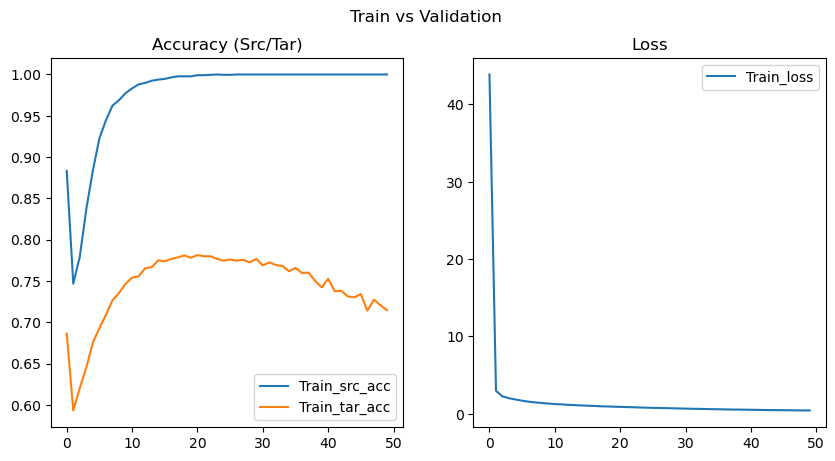

In [82]:
# model = torchvision.models.mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31).to(device)
# model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_small_reduce/best_model.pth', weights_only=True))
# student_fn = torch.load('/home/crueang/Chaks/AIOT_project/cp/mbv3_red_coral_A2D_prune_pre_structed_1k_freeze_before/best_model.pth', weights_only=False, map_location=device)
# student_fn = student_fn.to(device)
# summary(student_fn, (3, 224, 224))
path_save_cp = f'{HOME}/cp/mbv3_red_coral_A2D_prune_struct_1k_freeze_before_5_0_2/'
optimizer = optim.Adam(student_fn.parameters(), 1e-3)

for module in student_fn.modules():
    if hasattr(module, '_forward_hooks'):
        module._forward_hooks.clear()

student_fn = student_fn.to(device)

if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)

train_coral(student_fn, optimizer, Dl_amazon, Dl_dslr, Dl_dslr_test, path_save_cp)


torch.save(student_fn, path_save_cp+'coral_A-D.pth')

In [75]:
student_fn = torch.load(f'{HOME}/cp/mbv3_red_coral_A2D_prune_pre_structed_1k_freeze_before_0_2/model.pth', weights_only=False, map_location=device)
student_fn = student_fn.to(device)
for name, param in student_fn.named_parameters():
    if 'features' in name and int(name.split('.')[1]) < 11:
        param.requires_grad = False
    else:
        param.requires_grad = True
    print(f'Layer: {name}, requires_grad: {param.requires_grad}')
summary(student_fn, (3, 224, 224))
count_model_param_flops(model=student_fn.cpu().eval(), input_res=224, multiply_adds=True)

Layer: features.0.0.weight, requires_grad: False
Layer: features.0.1.weight, requires_grad: False
Layer: features.0.1.bias, requires_grad: False
Layer: features.1.block.0.0.weight, requires_grad: False
Layer: features.1.block.0.1.weight, requires_grad: False
Layer: features.1.block.0.1.bias, requires_grad: False
Layer: features.1.block.1.fc1.weight, requires_grad: False
Layer: features.1.block.1.fc1.bias, requires_grad: False
Layer: features.1.block.1.fc2.weight, requires_grad: False
Layer: features.1.block.1.fc2.bias, requires_grad: False
Layer: features.1.block.2.0.weight, requires_grad: False
Layer: features.1.block.2.1.weight, requires_grad: False
Layer: features.1.block.2.1.bias, requires_grad: False
Layer: features.2.block.0.0.weight, requires_grad: False
Layer: features.2.block.0.1.weight, requires_grad: False
Layer: features.2.block.0.1.bias, requires_grad: False
Layer: features.2.block.1.0.weight, requires_grad: False
Layer: features.2.block.1.1.weight, requires_grad: False
La

tensor(17436188.)

In [73]:
optimizer = torch.optim.Adam(student_fn.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
train_set, test_set = random_split(dslr_dataset, [0.2, 0.8])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
checkpoint_path = f'{HOME}/cp/pruning/pre_structed_1k_freeze_features_0_2/'

In [74]:
train(student_fn, optimizer, criterion, train_loader, test_loader, 50, checkpoint_path, device=device)

🤖Training on cuda


🚀Training Epoch [1/50]:   0%|          | 0/7 [00:00<?, ?batch/s]

🚀Training Epoch [1/50]: 100%|██████████| 7/7 [00:01<00:00,  5.76batch/s]



	Train loss: 0.04858837932348251
	Train acc: 0.9


📄Testing: 100%|██████████| 25/25 [00:03<00:00,  6.57batch/s]


	Test loss: 0.0063480936943193025
	Test acc: 0.9748743718592965


🚀Training Epoch [2/50]: 100%|██████████| 7/7 [00:00<00:00,  7.23batch/s]



	Train loss: 0.020093266256153583
	Train acc: 0.87


📄Testing: 100%|██████████| 25/25 [00:03<00:00,  6.59batch/s]


	Test loss: 0.006772229425730792
	Test acc: 0.964824120603015


🚀Training Epoch [3/50]: 100%|██████████| 7/7 [00:00<00:00,  7.20batch/s]



	Train loss: 0.020579888373613357
	Train acc: 0.9


📄Testing:  64%|██████▍   | 16/25 [00:02<00:01,  6.37batch/s]


KeyboardInterrupt: 

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
model = torch.load(f'{HOME}/cp/mbv3_red_coral_A2D_prune_pre_structed_1k_freeze_before_0_2/model.pth', weights_only=False, map_location=device)
summary(model, (3, 224, 224))
count_model_param_flops(model=model.cpu().eval(), input_res=224, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

tensor(17436188.)

In [31]:
DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'
HOME = '/home/crueang/Chaks/AIOT_project'

In [47]:
PREVIOUS_MODEL = f'{CP}/prune/global_prune/v1/best_model.pth'

In [48]:
student_fn_globpruned = torch.load(PREVIOUS_MODEL, weights_only=False, map_location=device)
summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_globpruned.cpu().eval(), input_res=image_size, multiply_adds=True)
# f = student_fn_globpruned.features
# C = student_fn_globpruned.classifier
# print(f)
# for name, module in model.named_modules():
#     if hasattr(module, 'weight'):
#         num_params = module.weight.numel()  # Get number of parameters in the layer
#         if num_params > 1000:
#             print(name, num_params)
        #     flag = 0
        #     print(f'Pruning layer {name} with {num_params} parameters')
        #     prune.l1_unstructured(module, name='weight', amount=amount)
        #     # prune.remove(module, 'weight')

        # if flag == 1:
        #     for param in module.parameters():
        #         param.requires_grad = False
        #         print(f'Layer {name}: {num_params} parameters frozen')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

tensor(16486875.)

In [49]:
"""
So far, we only looked at what is usually referred to as “local” pruning, i.e.,
the practice of pruning tensors in a model one by one, by comparing the
statistics (weight magnitude, activation, gradient, etc.) of each entry
exclusively to the other entries in that tensor. However, a common and perhaps
more powerful technique is to prune the model all at once, by removing
(for example) the lowest 20% of connections across the whole model, instead of
removing the lowest 20% of connections in each layer. This is likely to result
in different pruning percentages per layer. Let’s see how to do that using
global_unstructured from 'torch.nn.utils.prune.'
"""
import copy
import torch.nn.utils.prune as prune

student_fn_globpruned = torch.load(PREVIOUS_MODEL, weights_only=False, map_location=device)
f = student_fn_globpruned.features
C = student_fn_globpruned.classifier
f_allpruned = copy.deepcopy(f)
C_allpruned = copy.deepcopy(C)

parameters_to_prune = (
    
    # (f_allpruned[4].block[0][0], 'weight'),
    # (f_allpruned[4].block[1][0], 'weight'),
    # (f_allpruned[4].block[2].fc1, 'weight'),
    # (f_allpruned[4].block[2].fc2, 'weight'),
    # (f_allpruned[4].block[3][0], 'weight'),
    
    # (f_allpruned[5].block[0][0], 'weight'),
    # (f_allpruned[5].block[1][0], 'weight'),
    # (f_allpruned[5].block[2].fc1, 'weight'),
    # (f_allpruned[5].block[2].fc2, 'weight'),
    # (f_allpruned[5].block[3][0], 'weight'),
    
    (f_allpruned[6].block[0][0], 'weight'),
    (f_allpruned[6].block[1][0], 'weight'),
    (f_allpruned[6].block[2].fc1, 'weight'),
    (f_allpruned[6].block[2].fc2, 'weight'),
    (f_allpruned[6].block[3][0], 'weight'),
    
    (f_allpruned[7].block[0][0], 'weight'),
    (f_allpruned[7].block[1][0], 'weight'),
    (f_allpruned[7].block[2].fc1, 'weight'),
    (f_allpruned[7].block[2].fc2, 'weight'),
    (f_allpruned[7].block[3][0], 'weight'),
    
    # (f_allpruned[8].block[0][0], 'weight'),
    # (f_allpruned[8].block[1][0], 'weight'),
    # (f_allpruned[8].block[2].fc1, 'weight'),
    # (f_allpruned[8].block[2].fc2, 'weight'),
    # (f_allpruned[8].block[3][0], 'weight'),
    
    # (f_allpruned[9].block[0][0], 'weight'),
    # (f_allpruned[9].block[1][0], 'weight'),
    # (f_allpruned[9].block[2].fc1, 'weight'),
    # (f_allpruned[9].block[2].fc2, 'weight'),
    # (f_allpruned[9].block[3][0], 'weight'),
    
    # (f_allpruned[10].block[0][0], 'weight'),
    # (f_allpruned[10].block[1][0], 'weight'),
    # (f_allpruned[10].block[2].fc1, 'weight'),
    # (f_allpruned[10].block[2].fc2, 'weight'),
    # (f_allpruned[10].block[3][0], 'weight'),
    
    # (f_allpruned[11].block[0][0], 'weight'),
    # (f_allpruned[11].block[1][0], 'weight'),
    # (f_allpruned[11].block[2].fc1, 'weight'),
    # (f_allpruned[11].block[2].fc2, 'weight'),
    # (f_allpruned[11].block[3][0], 'weight'),

    # (C_allpruned[0], 'weight'),
    # (C_allpruned[3], 'weight'),
)

# Pruning the same setting
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.10,
)

student_fn_globpruned = torch.load(PREVIOUS_MODEL, weights_only=False, map_location=device)
student_fn_globpruned.features = f_allpruned
student_fn_globpruned.classifier = C_allpruned
student_fn_globpruned.to(device)
summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_globpruned.cpu().eval(), input_res=224, multiply_adds=True)
for module in student_fn_globpruned.modules():
    if hasattr(module, '_forward_hooks'):
        module._forward_hooks.clear()
PATH_SAVE = '/home/crueang/Chaks/AIOT_project/cp/pruning/global_prune/v1/pruned.pth'
torch.save(student_fn_globpruned.cpu().eval(), PATH_SAVE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

In [50]:
model = torch.load(PATH_SAVE, weights_only=False, map_location=device)
summary(model, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=model.cpu().eval(), input_res=image_size, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

tensor(16298461.)

In [51]:
model = torch.load(PATH_SAVE, weights_only=False, map_location=device)
summary(model, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=model.cpu().eval(), input_res=image_size, multiply_adds=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=False)
checkpoint_path = f'{CP}/prune/global_prune/v2/'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

In [53]:
for name, param in model.named_parameters():
    if 'features' in name and int(name.split('.')[1]) < 9:
        param.requires_grad = False
    else:
        param.requires_grad = True
    print(f'Layer: {name}, requires_grad: {param.requires_grad}')

Layer: features.0.0.weight, requires_grad: False
Layer: features.0.1.weight, requires_grad: False
Layer: features.0.1.bias, requires_grad: False
Layer: features.1.block.0.0.weight, requires_grad: False
Layer: features.1.block.0.1.weight, requires_grad: False
Layer: features.1.block.0.1.bias, requires_grad: False
Layer: features.1.block.1.fc1.weight, requires_grad: False
Layer: features.1.block.1.fc1.bias, requires_grad: False
Layer: features.1.block.1.fc2.weight, requires_grad: False
Layer: features.1.block.1.fc2.bias, requires_grad: False
Layer: features.1.block.2.0.weight, requires_grad: False
Layer: features.1.block.2.1.weight, requires_grad: False
Layer: features.1.block.2.1.bias, requires_grad: False
Layer: features.2.block.0.0.weight, requires_grad: False
Layer: features.2.block.0.1.weight, requires_grad: False
Layer: features.2.block.0.1.bias, requires_grad: False
Layer: features.2.block.1.0.weight, requires_grad: False
Layer: features.2.block.1.1.weight, requires_grad: False
La

In [54]:
train(model, optimizer, criterion, train_loader, test_loader, 50, checkpoint_path, device=device)

🤖Training on cuda


🚀Training Epoch [1/50]: 100%|██████████| 177/177 [00:11<00:00, 15.82batch/s]



	Train loss: 0.01164968422193174
	Train acc: 0.952076677316294


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.14batch/s]


	Test loss: 0.009467706091182191
	Test acc: 0.9477911646586346


RuntimeError: Parent directory /home/crueang/Chaks/AIOT_project/democp/prune/global_prune/v2 does not exist.

In [55]:
correct = 0
total = 0

dslr_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transformer)
Dl_dslr = DataLoader(dslr_dataset, batch_size, shuffle=False)

model = torch.load('/home/crueang/Chaks/AIOT_project/democp/prune/global_prune/v1/best_model.pth', weights_only=False, map_location=device)

with torch.no_grad():
    for data in Dl_dslr:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        correct += (outputs.argmax(1) == labels).float().sum().item()
        total += labels.shape[0]
        

print('Accuracy : %f %%' % (100 * correct / total))

Accuracy : 96.787149 %


In [2]:
def load_training_logs(checkpoint_path):
    training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
    epoch_number = len(training_logs['train_loss'])
    
    for i in range(min(epoch_number, 50)):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()
    
    print('best test acc', max(training_logs['validate_acc']))

In [5]:
checkpoint_path = '/home/crueang/Chaks/AIOT_project/cp/mbv3_large_ref/'

load_training_logs(checkpoint_path)

Epochs 1  train_loss: 0.07780 validate_loss: 0.04253 train_acc: 0.65815 validate_acc: 0.81582 
Epochs 2  train_loss: 0.03737 validate_loss: 0.01691 train_acc: 0.83844 validate_acc: 0.91995 
Epochs 3  train_loss: 0.02680 validate_loss: 0.03695 train_acc: 0.87591 validate_acc: 0.84745 
Epochs 4  train_loss: 0.02357 validate_loss: 0.01864 train_acc: 0.89367 validate_acc: 0.91192 
Epochs 5  train_loss: 0.02091 validate_loss: 0.03554 train_acc: 0.90438 validate_acc: 0.85401 
Epochs 6  train_loss: 0.01458 validate_loss: 0.01169 train_acc: 0.92968 validate_acc: 0.95182 
Epochs 7  train_loss: 0.01558 validate_loss: 0.00652 train_acc: 0.92336 validate_acc: 0.96813 
Epochs 8  train_loss: 0.01149 validate_loss: 0.01724 train_acc: 0.94599 validate_acc: 0.92798 
Epochs 9  train_loss: 0.01572 validate_loss: 0.01213 train_acc: 0.93236 validate_acc: 0.94842 
Epochs 10 train_loss: 0.00967 validate_loss: 0.00932 train_acc: 0.94964 validate_acc: 0.95864 
Epochs 11 train_loss: 0.01036 validate_loss: 0.009